# Merge two traces from Track Mate

In [89]:

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./_modules")
import TrackMerger as tm

import numpy as np
import math

import TrackTiffDataExtractor as tiffExtractor


############
#parameters
############

#trackListFileA = "/Volumes/SCIENCE 1/science/mary_atg/3_atg13GFP_atg8Cherry/0426 MG134/134_M1_GFPstack_Tracks.xml"
#trackListFileB = "/Volumes/SCIENCE 1/science/mary_atg/3_atg13GFP_atg8Cherry/0426 MG134/134_M1_RFPstack_Tracks.xml"
trackListFileA = "./input/134_M1_GFPstack_Tracks.xml"
trackListFileB = "./input/134_M1_RFPstack_Tracks.xml"

fpA = r'./input/m2_w1L-SP_GFPex_t_all.tif'
fpB = r'./input/m2_w2L-SP_RFPex_t_all.tif'

outputFolder = "./output2/"

#distance in pixels below which two tracks are regarded as potential matches
matchDistanceTreshold = 10;

# number of time points collected in every stack
maxNTimePoints=49

In [90]:
# this method tests multiple distance tresholds for track matching. 
# The distance treshold should be chosen such that the searchradius does not become too large
# to include fals positive matches (10px is a good choice)

# this has only to be done once
#tm.determineDistanceTresholdForMatching(trackListFileA,trackListFileB,matchDistanceTreshold)

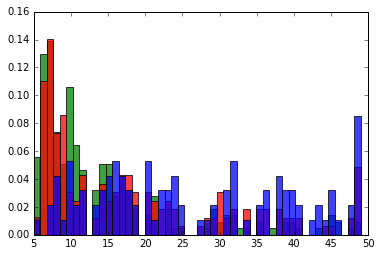

In [91]:
uniqueTracksA,uniqueTracksB,mergedTracksAB = tm.matchTracks(trackListFileA,trackListFileB,matchDistanceTreshold,maxNTimePoints,verbose=False)

tm.plotTrackLengthHistogram(tm.parseTraceListFromFile(trackListFileA),'green')
tm.plotTrackLengthHistogram(tm.parseTraceListFromFile(trackListFileB),'red')
tm.plotTrackLengthHistogram(mergedTracksAB,'blue')

mergedTracksAB_readyForTiffExtraction = tm.preprocessTracksForTiffExtraction(mergedTracksAB,maxNTimePoints)

# Get the data from the TIFF files

In [92]:


# I had to comment out the tif.close() in order to avoid a UnboundLocalError exception.


stackA = tiffExtractor.readStack(fpA)
stackB = tiffExtractor.readStack(fpB)


# Investigate One particular Track

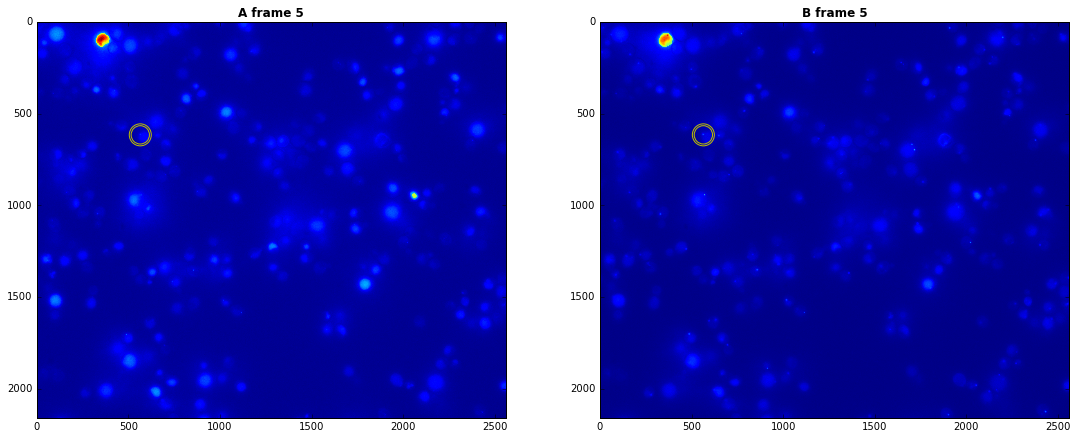

In [93]:
#TrackIdWeAreInterestedIn = 19
##
#trackAvgPosition = tm.getAveragePositionForTrack(mergedTracksAB[TrackIdWeAreInterestedIn])
#tiffExtractor.plotTrackCoordinatesInBothStackFrames(stackA,stackB,5,(trackAvgPosition[0],trackAvgPosition[1]))
#
#

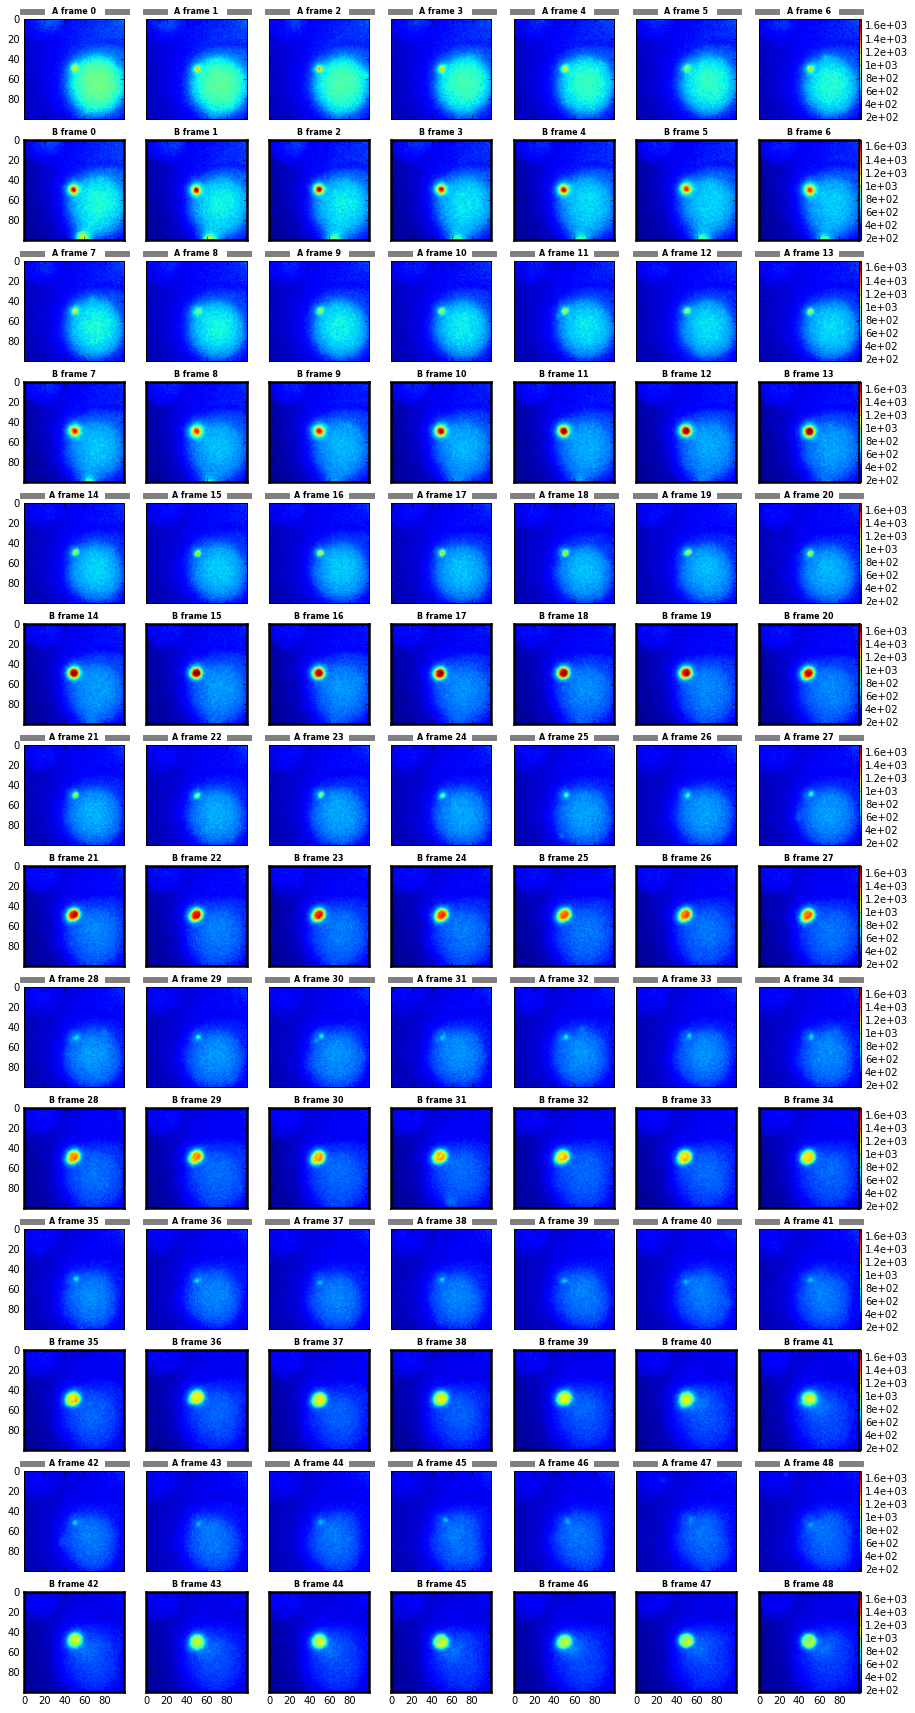

In [94]:
#trackToPlotCoordinates = mergedTracksAB_readyForTiffExtraction[TrackIdWeAreInterestedIn]
#imageSize = 100
#trackFocusImages_stackA = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackA,imageSize/2)
#trackFocusImages_stackB = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackB,imageSize/2)
##
#tiffExtractor.showTwoListsOfImagesOneBelowTheOtherInSubplotGrid_colorbar(trackFocusImages_stackA,trackFocusImages_stackB,7,'test.jpg')

# Fit Gaussian

In [95]:
def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [96]:
import pandas
import scipy.optimize as opt
def fitGaussianGuess(particleImage,initial_guess = (30000.,15.,15.,5.,5.,1.,1.)):
    x = range(0,len(particleImage))
    y = range(0,len(particleImage[0]))
    (x, y) = np.meshgrid(x, y)
    # (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)

    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), particleImage.reshape(len(particleImage)*len(particleImage[0])), p0=initial_guess)
        debug = False
        if(debug):
            paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
            asdf=pandas.DataFrame(zip( initial_guess, popt,initial_guess-popt),paramLabels,["initParam","popt","diff"])
            print(asdf)
    except RuntimeError:
        return([0,0,0,0,0,0,0])
#    return([popt[0]-popt[6], # (amplitude-offset
#            (popt[3]+popt[4])/2., # mean(sigmas)
#            popt[0], #amplitude
#            popt[3],#sigmaX
#            popt[4], #sigmaY
#            popt[6]])#offset
    return popt
 

In [97]:
import pandas
import scipy.optimize as opt
def fitGaussian(particleImage):
    x = range(0,len(particleImage))
    y = range(0,len(particleImage[0]))
    (x, y) = np.meshgrid(x, y)
    # (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
    initial_guess = (30000.,len(particleImage)/2.,len(particleImage)/2.,5.,5.,1.,1.)
    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), particleImage.reshape(len(particleImage)*len(particleImage[0])), p0=initial_guess)
        debug = False
        if(debug):
            paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
            asdf=pandas.DataFrame(zip( initial_guess, popt,initial_guess-popt),paramLabels,["initParam","popt","diff"])
            print(asdf)
    except RuntimeError:
        return([0,0,0,0,0,0,0])
#    return([popt[0]-popt[6], # (amplitude-offset
#            (popt[3]+popt[4])/2., # mean(sigmas)
#            popt[0], #amplitude
#            popt[3],#sigmaX
#            popt[4], #sigmaY
#            popt[6]])#offset
    return popt
 

In [98]:
def plotGaussianFit(particleImage,popt,option="gauss"):
    x = range(0,len(particleImage))
    y = range(0,len(particleImage[0]))
    (x, y) = np.meshgrid(x, y)
    
    if(popt[0]==None):
        plt.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower'
        plt.show()
        return(None)
    
    data_fitted = twoD_Gaussian((x, y), *popt)

    if(option=="all"):
        fig, axs = plt.subplots(1, 3)
        ax = axs[0]
        ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
        
        ax = axs[1]
        ax.imshow(data_fitted.reshape(len(particleImage), len(particleImage)))#,origin='lower')
        
        ax = axs[2]
        ax.hold(True)
        ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
        ax.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage)), 8, colors='w')
        fig.show()
    if(option=="gauss"):
        plt.imshow(data_fitted.reshape(len(particleImage), len(particleImage)))#,origin='lower')
        plt.show()
    if(option=="overlay"):
        plt.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
        plt.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage)), 8, colors='w')
        plt.show()
    return(data_fitted.reshape(len(particleImage), len(particleImage)))


In [99]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [100]:
def getMaxIntensityCoordinates(particleImg):
    currentMax = 0
    maxX = 0
    maxY = 0
    
    for i in range (0,len(particleImg)):
        for j in range (0,len(particleImg[0])):
            if particleImg[i,j] > currentMax:
                maxX = i;
                maxY = j;
                currentMax = particleImg[i,j]

    return([maxX,maxY])

In [101]:
### Plotting function for the Track focus images in two conditions, have a colorbar as well

# the clipping treshold is an normalized intensity value above which pixel intensities are treated as puncta
# and below which it is regarded as other intensity sources (noise, cell fluorescence)
# it prooved well to use the brightest 10% of the pixels to determine the puncta, i.e. the value is 0.9
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
def doGaussianFitAndPlotResults(imageListA,imageListB,nColumns,outputFilename="output.png"):
    setBlinewidth = 2.5
    stack = imageListA
    # the min and max values of the color map
    vMax = np.max((np.max((imageListA[0])),np.max((imageListB[0]))))
    vMin = np.min((np.min((imageListA[0])),np.min((imageListB[0]))))
    xRange = len(imageListA[0])
    yRange = len(imageListA[0][0])
    
    
    
    #n columns for display
    nRows = int(math.ceil(len(stack)/nColumns))
    rowCounter = 0
    colCounter = 0
    frameSubtractor=0
    
    plt.close('all')
    fig, axs = plt.subplots(nrows=2*nRows, ncols=nColumns, sharex=True, sharey=True)    
    gaussianFitResults_A = []
    gaussianFitResults_B = []
    
    for counter in range(0,2*len(stack)):
        frameId = counter-frameSubtractor
        
        ax = axs[rowCounter][colCounter]
        
        #---- 
        # determine which image is plotted, from set A or B
        if(rowCounter%2==0):    
            particleImage = imageListA[frameId]
            ax.set_title("A frame "+str(frameId), fontsize=8, fontweight='bold')
            #make small horizontal bars
            ax.axvspan(0-0.04*xRange, xRange*0.2, 1.05, 1.1, clip_on=False,color='grey')
            ax.axvspan(xRange*0.8, xRange*1.04, 1.05, 1.1, clip_on=False,color='grey')
            
        else:        
            particleImage = imageListB[frameId]
            ax.set_title("B frame "+str(frameId), fontsize=8, fontweight='bold')
            # better distinguish the other condition:
            #ax.spines['top'].set_visible(False)
            ax.spines['top'].set_linewidth(setBlinewidth)
            ax.spines['right'].set_linewidth(setBlinewidth)
            ax.spines['bottom'].set_linewidth(setBlinewidth)
            ax.spines['left'].set_linewidth(setBlinewidth) 
    
        
        #---- 
        # perform the gaussian fit
        
        # where the magic happens
        # better clipping index:
        # the first index that is larger than 5 in the gradient distance 1.
        # but only search for that in the top 50% of the pixels
        
     #   mavg = 10
     #   gradDist = 3
     #   threshold = 0.3
     #   
     #   findIndexIn = moving_average(np.gradient(np.sort(particleImage.flatten()),gradDist),mavg)
     #   totalLen = len(findIndexIn)
     #   findIndexAfter = int(0.5*totalLen)
    #
     #   clippingIndex2 = findIndexAfter + next(x[0] for x in enumerate(findIndexIn[findIndexAfter:totalLen]) if x[1] > threshold)
     #   lowClipping2 = np.sort(particleImage.flatten())[clippingIndex2]
     #   
     #   clippedParticleImage=np.clip(particleImage, lowClipping2, np.max(particleImage))
#
     #   #determine the best fit
     #   #popt = fitGaussian(clippedParticleImage)
     #   maxIntensityCoords = getMaxIntensityCoordinates(clippedParticleImage)
     #   popt = fitGaussianGuess(clippedParticleImage,initial_guess = 
     #                     (np.max(clippedParticleImage),
     #                      maxIntensityCoords[0],
     #                      maxIntensityCoords[1],
     #                      5.,5.,
     #                      1.,
     #                      lowClipping2))
        
        #^^^^^^^^^^^^^
        
        mavg = 10
        gradDist = 3
        threshold = 0.3
    
        findIndexIn = moving_average(np.gradient(np.sort(particleImage.flatten()),gradDist),mavg)
        totalLen = len(findIndexIn)
        findIndexAfter = int(0.5*totalLen)

        clippingIndex2 = findIndexAfter + next(x[0] for x in enumerate(findIndexIn[findIndexAfter:totalLen]) if x[1] > threshold)
        lowClipping2 = np.sort(particleImage.flatten())[clippingIndex2]
        
    #print(clippingIndex2,lowClipping2)
    
        clippedParticleImage2=np.clip(particleImage, lowClipping2, np.max(particleImage))
    
     #popt = fitGaussian(clippedParticleImage2)
        maxIntensityCoords = getMaxIntensityCoordinates(clippedParticleImage2)
    # (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
#    if(poptFrameBefore[0]==0)
        popt = fitGaussianGuess(clippedParticleImage2,initial_guess = 
                          (np.max(clippedParticleImage2),
                           maxIntensityCoords[0],
                           maxIntensityCoords[1],
                           5.,5.,
                           1.,
                           lowClipping2))
        
        
        
        #--------------
        if(rowCounter%2==0):  
            gaussianFitResults_A.append(np.append(popt,lowClipping2))
        else:
            gaussianFitResults_B.append(np.append(popt,lowClipping2))
        

        #---- 
        # plot the results of the fit
        x = range(0,len(particleImage))
        y = range(0,len(particleImage[0]))
        (x, y) = np.meshgrid(x, y)
        data_fitted = twoD_Gaussian((x, y), *popt)

        im = ax.imshow(particleImage, cmap=plt.cm.jet,vmin=vMin, vmax=vMax)#,origin='lower')
        #if the fit failed, do not plot a contour
        if(popt[0]!=0):
            try:
#            ax.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage[0])), 8, colors='w')
                ax.contour(x, y, data_fitted.reshape(len(y), len(x)), 8, colors='w')
            except ValueError:
                print("oops")
                    #oops..
        
        #---- 
        # plot a color bar to the rightmost images

        
        # creates a new axis, cax, located 0.05 inches to the right of ax, whose width is 15% of ax
        # cax is used to plot a colorbar for each subplot
        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="2%",pad=None)# pad=0.05)
        #ticks=np.arange(0,10,.1),
        if(colCounter==nColumns-1):
            cbar = plt.colorbar(im, cax=cax,  format="%.2g")
            #cbar.set_label('Colorbar {}'.format(i), size=10)
        else:
            #cbar = plt.colorbar(im, cax=cax,  format="%.2g")
            # set the axes invisible if it is not used for a colorbar
            cax.axis('off')
            cax.get_xaxis().set_visible(False)
            cax.axes.get_yaxis().set_visible(False)

            
        #---- 
        # take care of rows and columns in the plot
        colCounter=colCounter+1;        
        if(colCounter>=nColumns):
            rowCounter = rowCounter+1;
            if(rowCounter%1==0):
                frameSubtractor +=nColumns
            if(rowCounter%2==0):
                frameSubtractor -=nColumns
            colCounter = 0
    
    
    fig.set_size_inches(15,45)
    fig.savefig(outputFilename, bbox_inches='tight')
    return [gaussianFitResults_A,gaussianFitResults_B]



In [106]:
#paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
def analyzeGaussFitResults(results,outputFilename):
    resultsA = results[0]
    resultsB = results[1]
    
    observables_A = computeObservables(resultsA)
    observables_B = computeObservables(resultsB)
    
    
    frameIds = range(0,len(resultsA))
    amplitudes_A = np.array(resultsA)[:,0]
    amplitudes_B = np.array(resultsB)[:,0]
    
    
    fig, axs = plt.subplots(3, 3,sharex=True)
    
    #offset = (np.array(gaussianFitResults[0:30]))[:,2]
    #x = [row[0] for row in gaussianFitResults[1:5]]
    #print(x)
    
    ##-- first row, amplitude
    ax = axs[0][0]
    ax.plot(frameIds,amplitudes_A,c='red')
    ax.set_title("A amplitude", fontsize=8, fontweight='bold')
    
    ax = axs[0][1]
    ax.plot(frameIds,amplitudes_B,c='black')
    ax.set_title("B amplitude", fontsize=8, fontweight='bold')
    
    ax = axs[0][2]
    ax.plot(frameIds,amplitudes_A/max(amplitudes_A),c='red')
    ax.plot(frameIds,amplitudes_B/max(amplitudes_B),c='black')
    ax.set_title("Amplitude", fontsize=8, fontweight='bold')
    
    ##-- scnd row, sigma
    ax = axs[1][0]
    ax.plot(frameIds,observables_A[3],c='red')
    ax.set_title("A FWHM", fontsize=8, fontweight='bold')
    
    ax = axs[1][1]
    ax.plot(frameIds,observables_B[3],c='black')
    ax.set_title("B FWHM", fontsize=8, fontweight='bold')
    
    ax = axs[1][2]
    ax.plot(frameIds,observables_A[3]/max(observables_A[3]),c='red')
    ax.plot(frameIds,observables_B[3]/max(observables_B[3]),c='black')
    ax.set_title("FWHM", fontsize=8, fontweight='bold')
    
    ##-- third row, volumes
    ax = axs[2][0]
    ax.plot(frameIds,observables_A[0])
    ax.plot(frameIds,observables_A[1])
    ax.plot(frameIds,observables_A[2],c='red')
    ax.set_title("A total intsty, gauss(blue), torus(green), both(red)", fontsize=8, fontweight='bold')
    
    ax = axs[2][1]
    ax.plot(frameIds,observables_B[0])
    ax.plot(frameIds,observables_B[1])
    ax.plot(frameIds,observables_B[2],c='black')
    ax.set_title("B total intsty, gauss(blue), torus(green), both(black)", fontsize=8, fontweight='bold')
    
    
    ax = axs[2][2]
    ax.plot(frameIds,observables_A[2]/max(observables_A[2]),c='red')
    ax.plot(frameIds,observables_B[2]/max(observables_B[2]),c='black')
    ax.set_title("total intsty", fontsize=8, fontweight='bold')
    
    
    fig.set_size_inches(10,10)
    fig.savefig(outputFilename, bbox_inches='tight')

In [107]:
#paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
#                   0         1     2     3          4          5        6
# 
def computeObservables(poptForOneCondition):
    totalVolumes = []
    torusVolumes = []
    gaussVolumes = []
    FWHMs = []
    for popt in poptForOneCondition:
    #if(popt[0]!=None and popt[3]<3 and popt[4]<3 and popt[6]<600):
    # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
        sigma = (abs(popt[3])+ abs(popt[4]))/2
        FWHM = 2.35*sigma
        FWHMs.append(FWHM)

        # torus volume Pi r^2 h
        torusVolume = math.pi * ((FWHM)/2)*((FWHM)/2) * popt[6]
        gaussVolume = 2* math.pi * popt[0] * abs(popt[3])* abs(popt[4])
        volume = torusVolume + gaussVolume
        totalVolumes.append(volume)
        torusVolumes.append(torusVolume)
        gaussVolumes.append(gaussVolume)
    return [gaussVolumes, torusVolumes, totalVolumes, FWHMs]

In [104]:
import csv
def writeGaussFitResultsFile(poptList,filename):
    with open(filename, 'wb') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in poptList:
            spamwriter.writerow(row)

## Analyze one trace

19


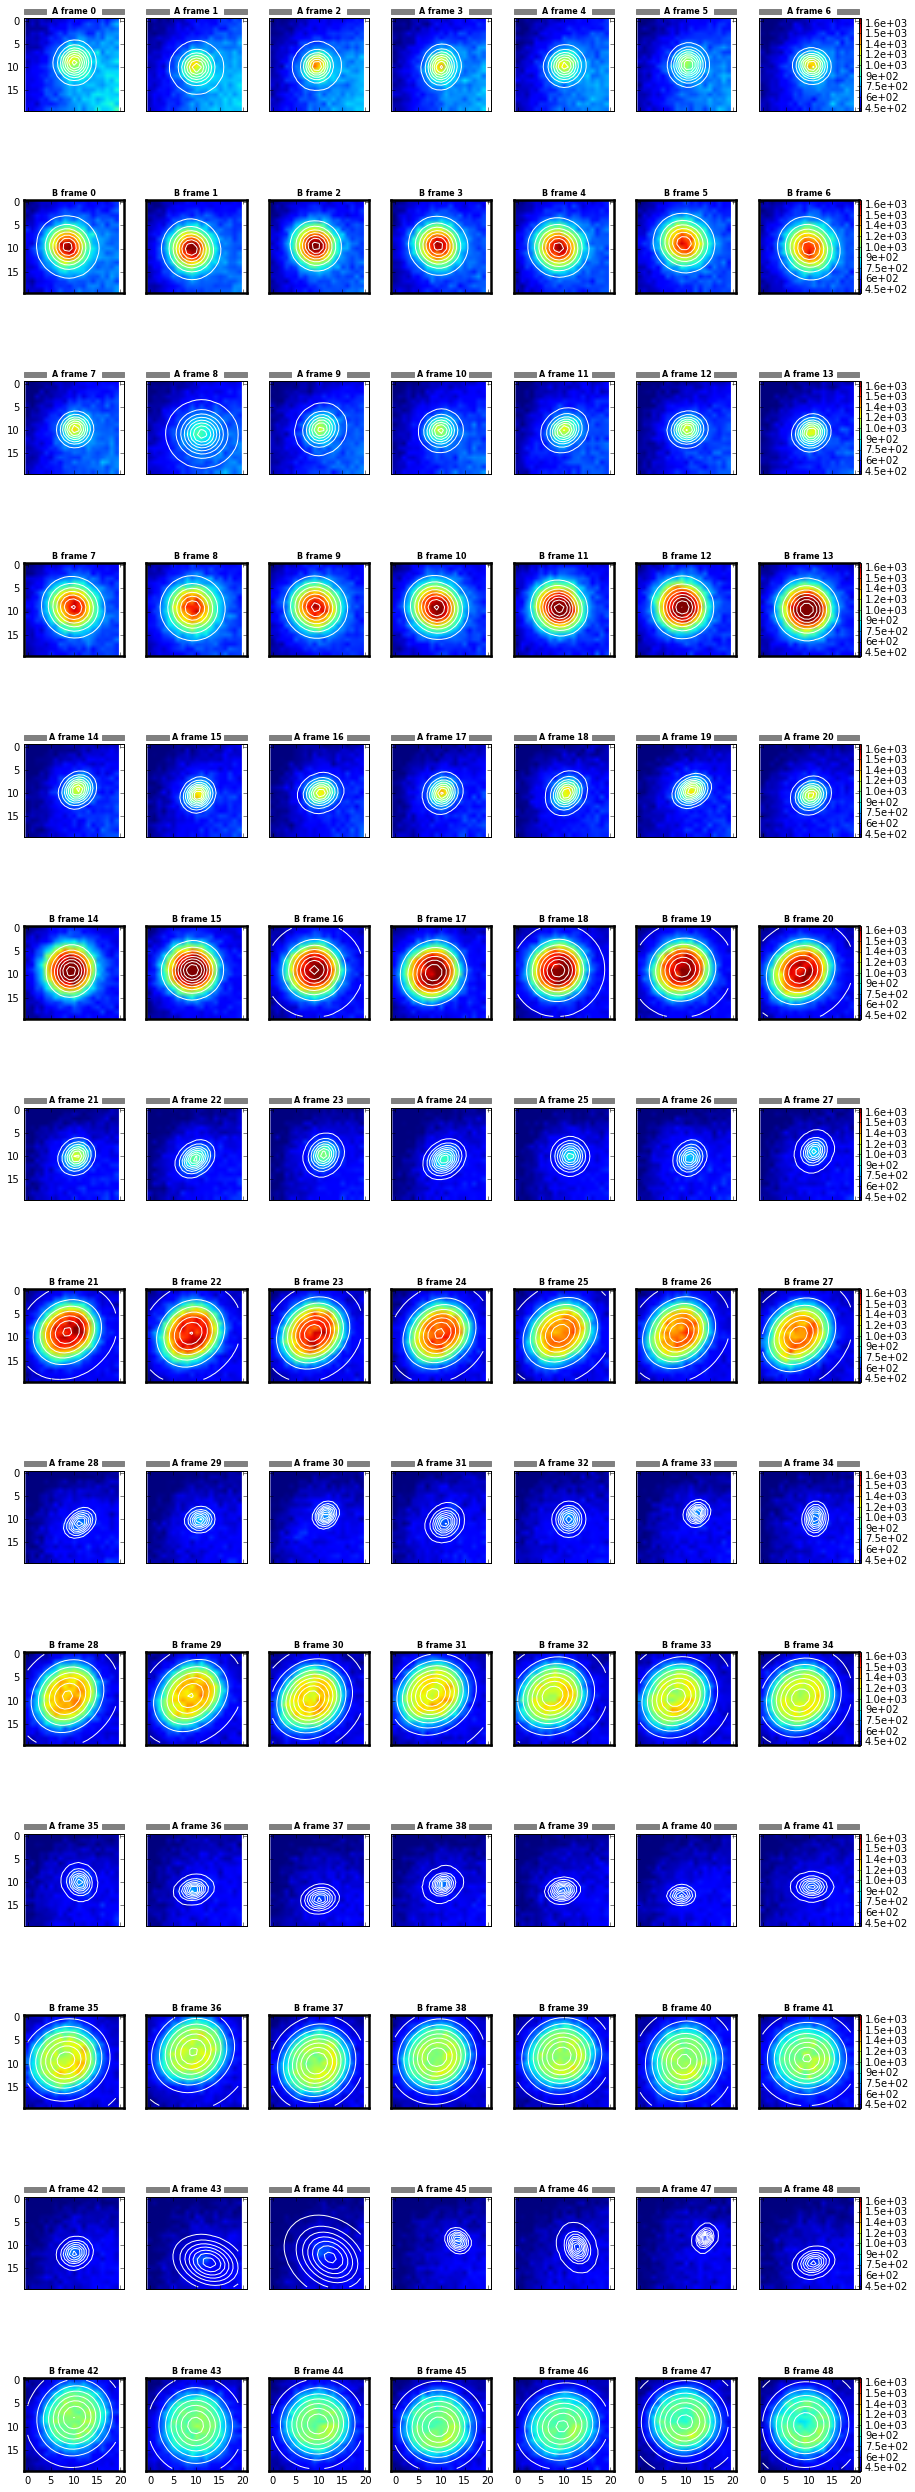

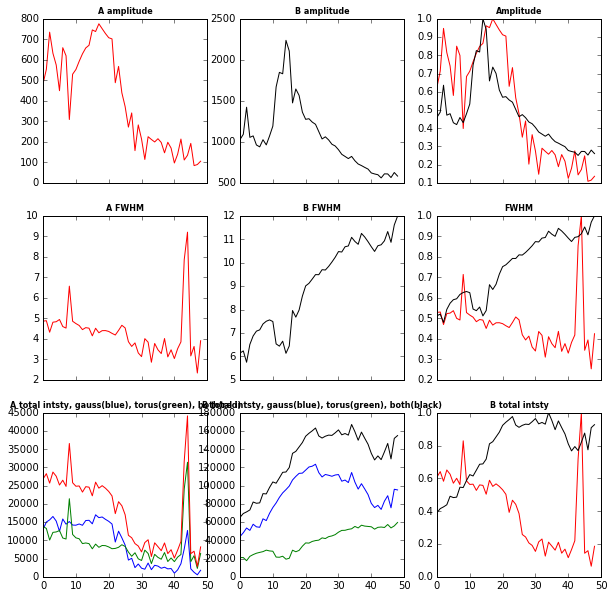

In [105]:
trackId = 19
    
print(trackId)
try:
    trackToPlotCoordinates = mergedTracksAB_readyForTiffExtraction[trackId]
    #----
    # plot the map of the puncta of interest
    trackAvgPosition = tm.getAveragePositionForTrack(mergedTracksAB[trackId])
    outputFilename = outputFolder+str(trackId)+"_1_map.png"
    tiffExtractor.plotTrackCoordinatesInBothStackFrames(stackA,stackB,5,(trackAvgPosition[0],trackAvgPosition[1]),outputFilename)
    #----
    # plot the raw images
    plotImagePad = 50
    nColumns = 7
    plotImages_stackA = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackA,plotImagePad)
    plotImages_stackB = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackB,plotImagePad)
    outputFilename = outputFolder+str(trackId)+"_2_puncta.png"
    tiffExtractor.showTwoListsOfImagesOneBelowTheOtherInSubplotGrid_colorbar(plotImages_stackA,plotImages_stackB,nColumns,outputFilename)
    #----
    # do the gaussian fit and plot the results
    fitImagePad = 10
    gaussFitImages_stackA = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackA,fitImagePad)
    gaussFitImages_stackB = tiffExtractor.extractTrackFocusImageFromStack(trackToPlotCoordinates,stackB,fitImagePad)
    outputFilename = outputFolder+str(trackId)+"_3_gaussFit.png"
    nColumns = 7
    fitResults = doGaussianFitAndPlotResults(gaussFitImages_stackA,gaussFitImages_stackB,nColumns,outputFilename)
    #fitResultsList.append(fitResults)
    #-----
    # write the results to a CSV file
    outputFilename = outputFolder+str(trackId)+"_3_gaussFit_A.csv"
    writeGaussFitResultsFile(fitResults[0],outputFilename)   
    outputFilename = outputFolder+str(trackId)+"_3_gaussFit_B.csv"
    writeGaussFitResultsFile(fitResults[1],outputFilename)   
    #-----
    # analyze the fit results
    outputFilename = outputFolder+str(trackId)+"_4_gaussFit_analysis.png"
    analyzeGaussFitResults(fitResults,outputFilename)
except ValueError:
    print("somethingWentWrong")

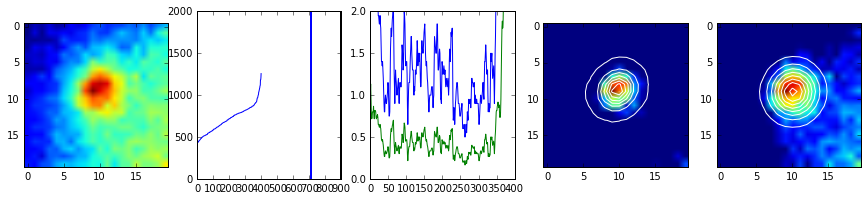

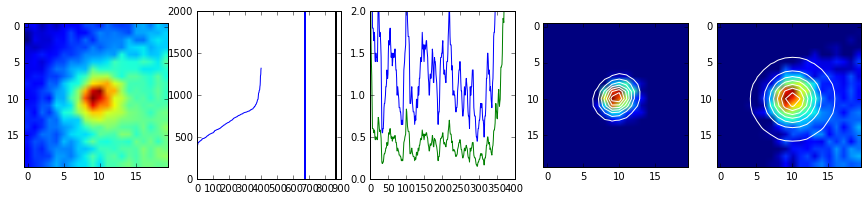

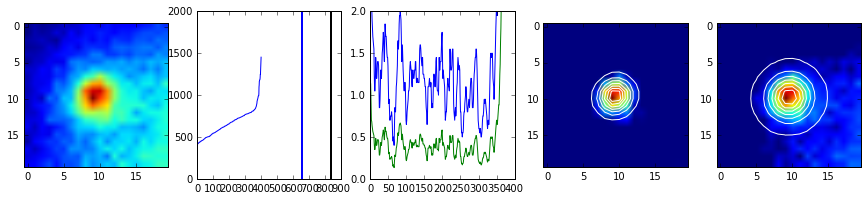

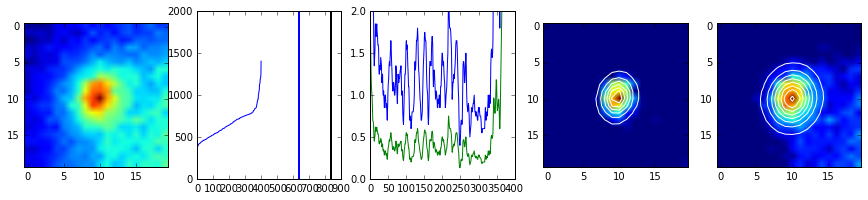

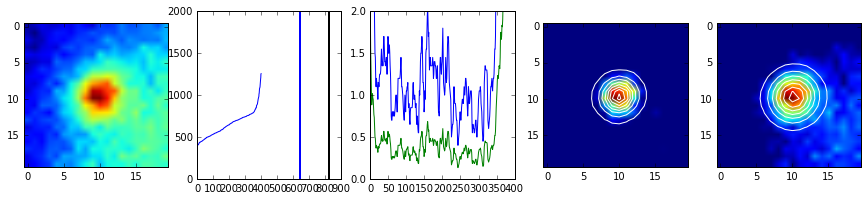

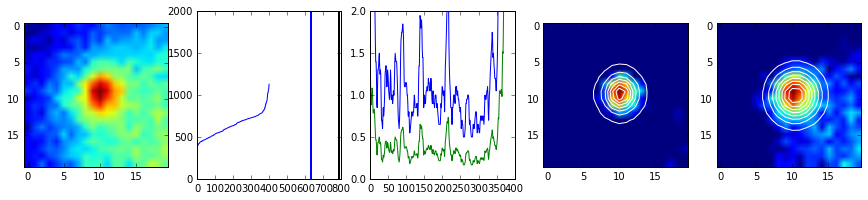

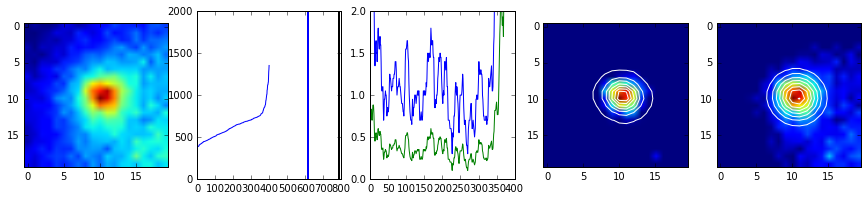

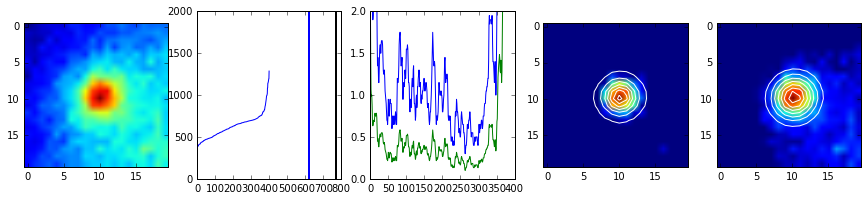

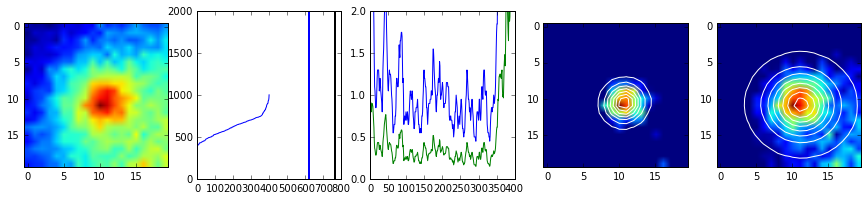

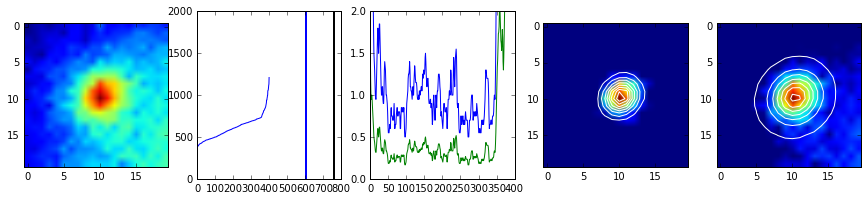

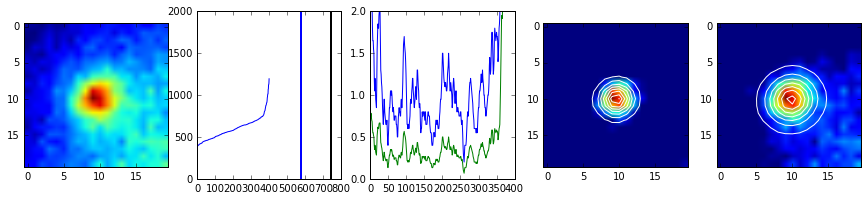

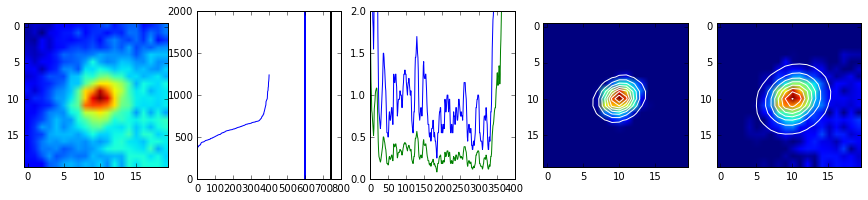

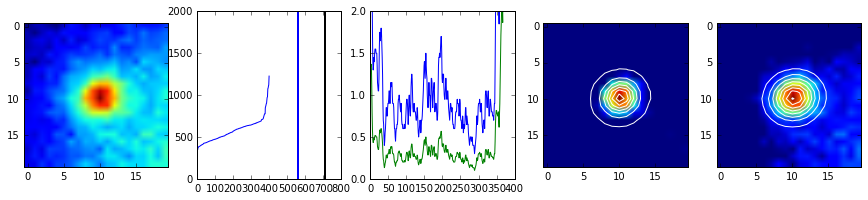

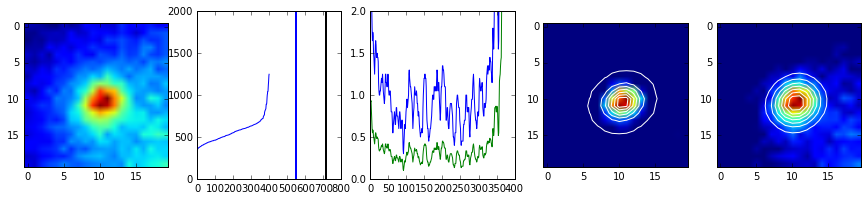

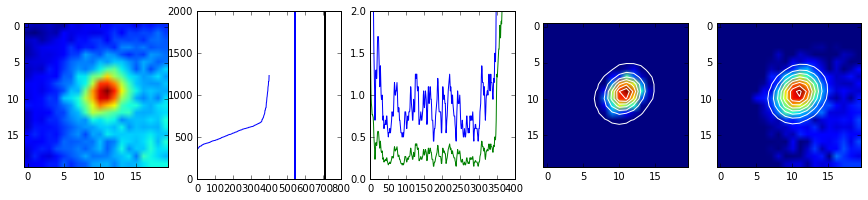

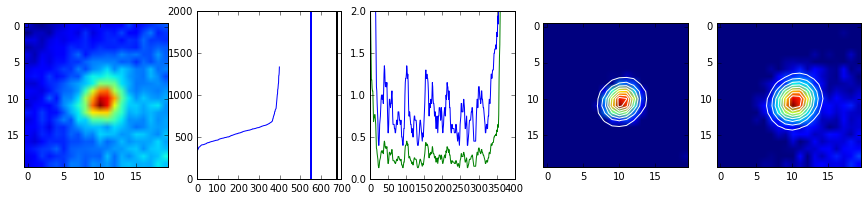

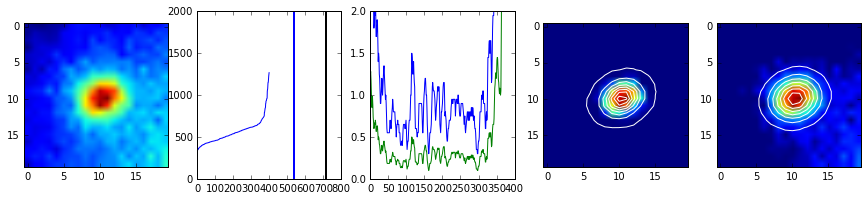

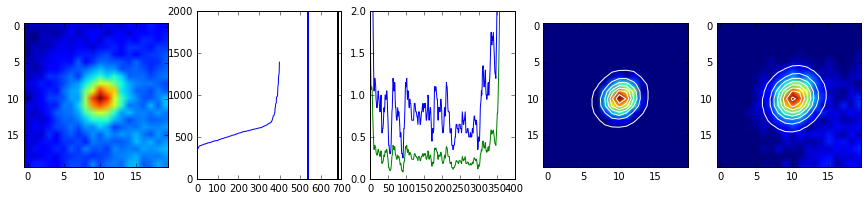

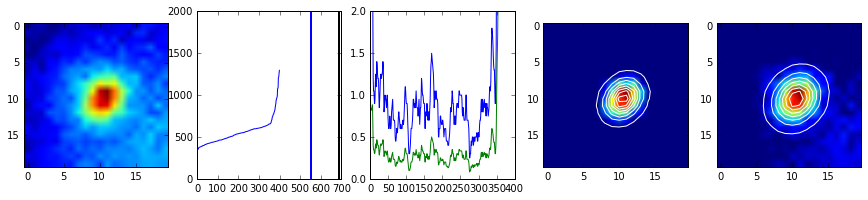

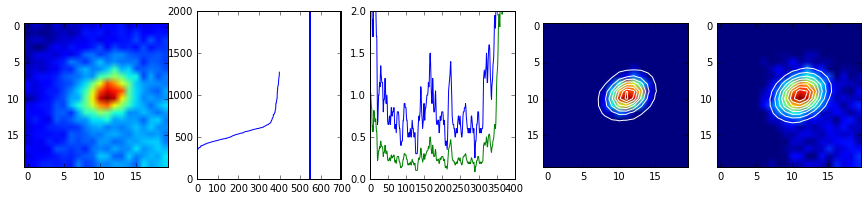

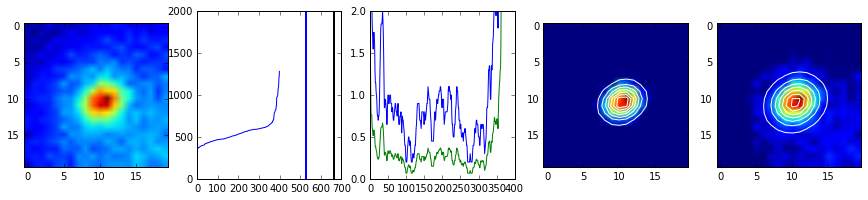

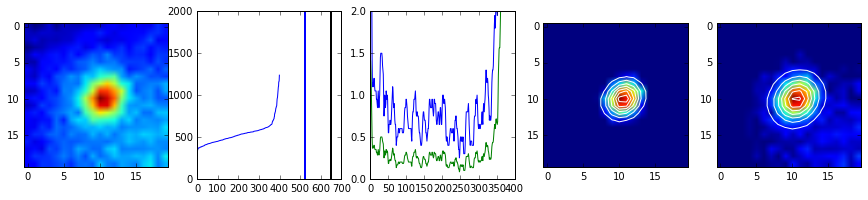

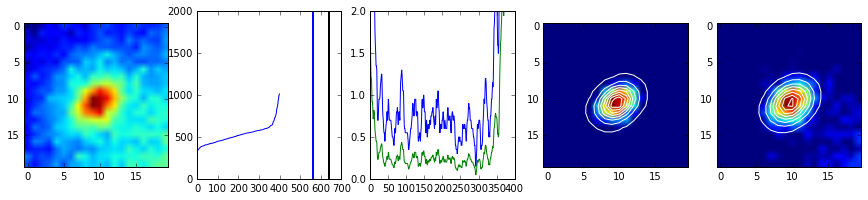

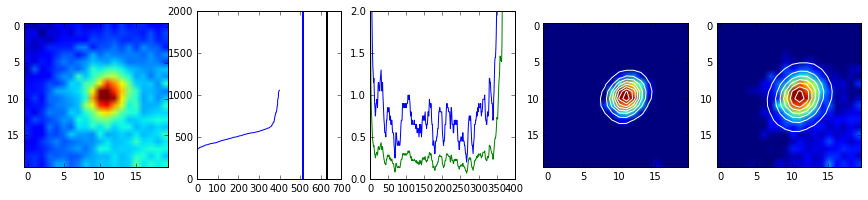

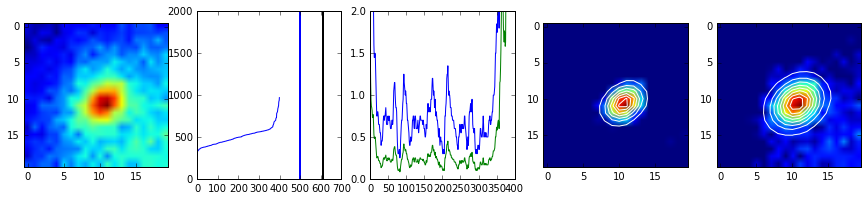

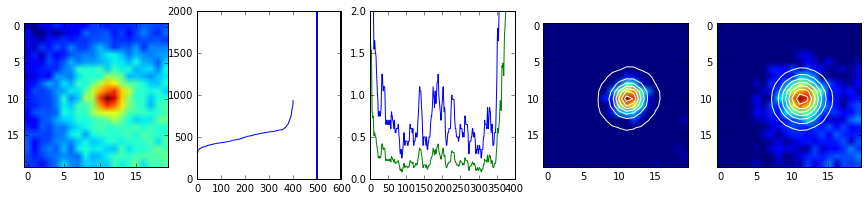

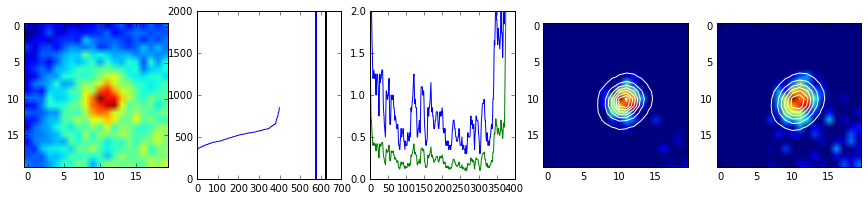

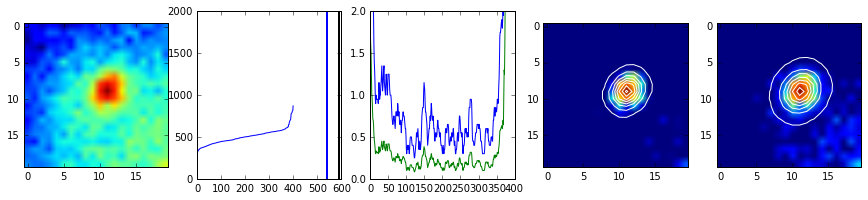

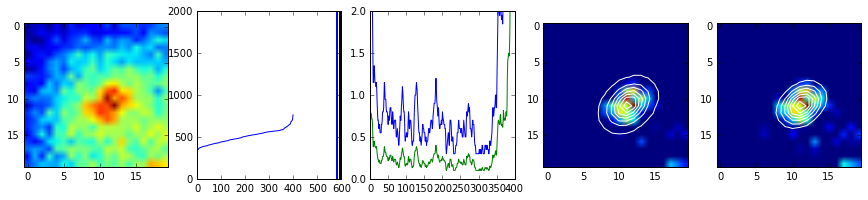

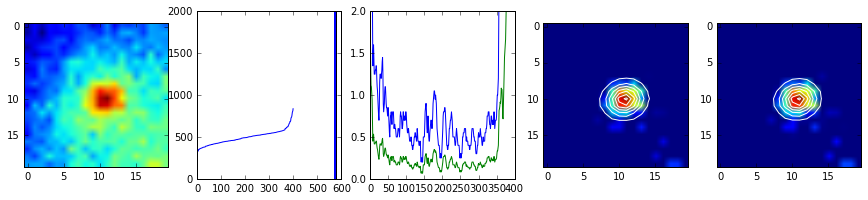

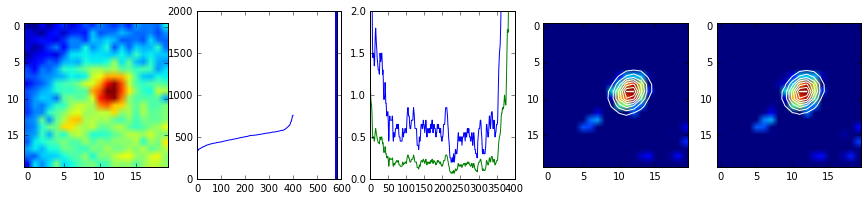

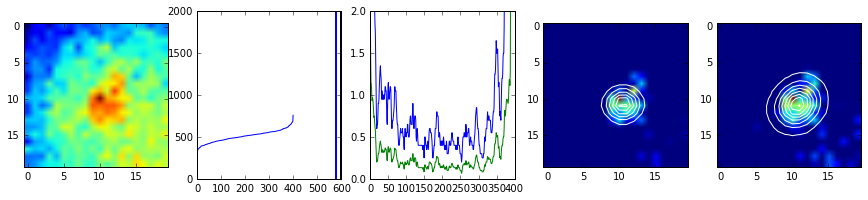

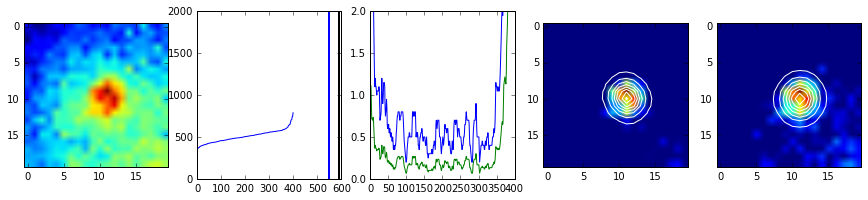

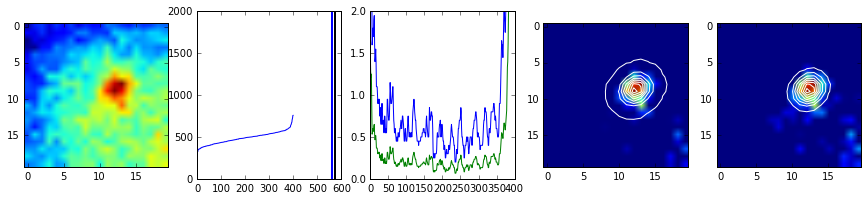

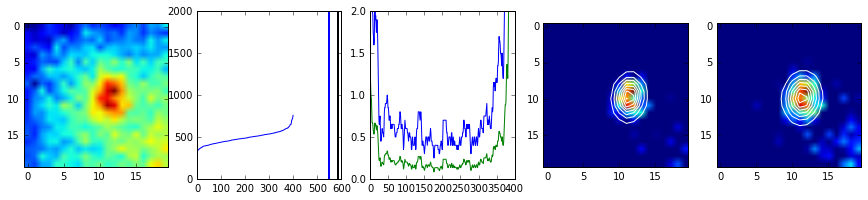

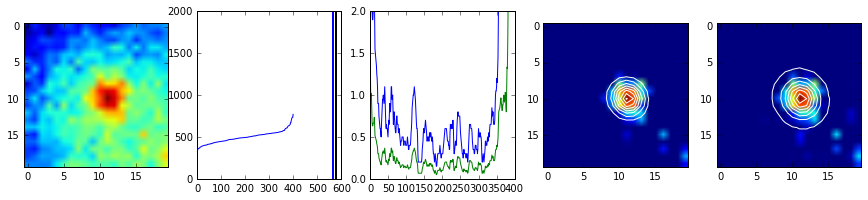

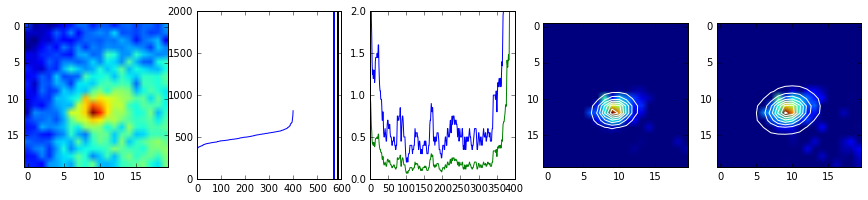

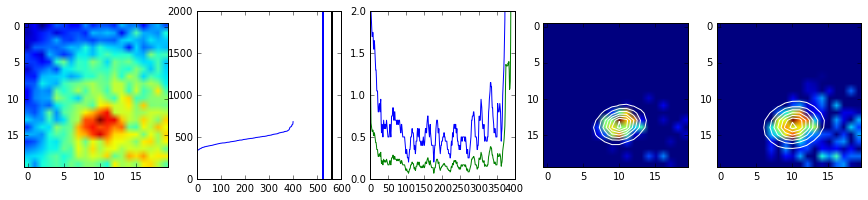

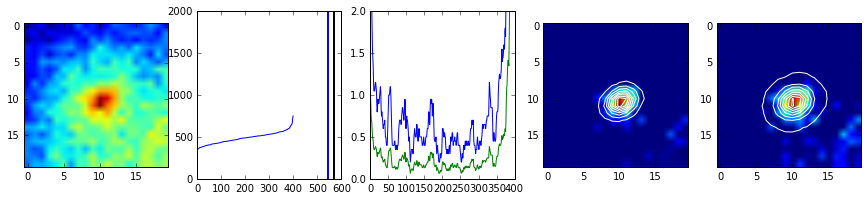

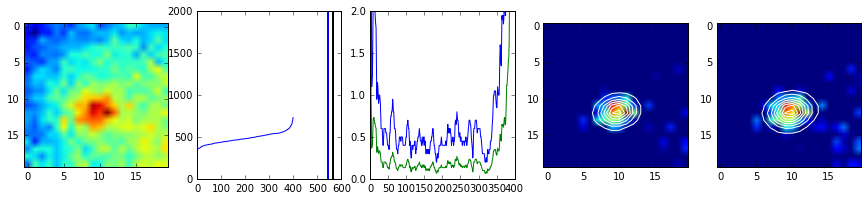

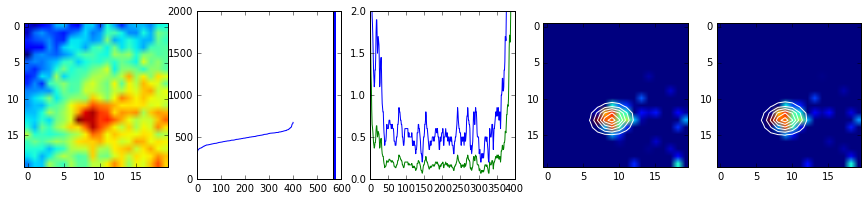

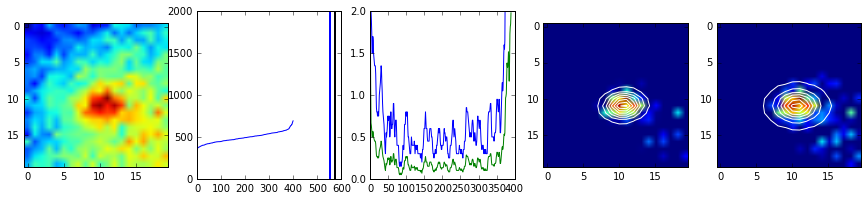

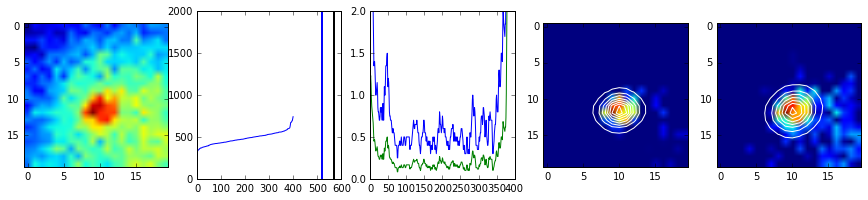

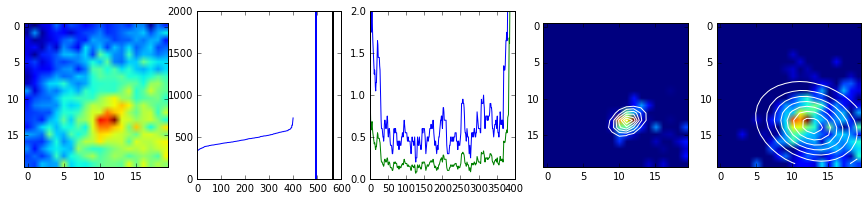

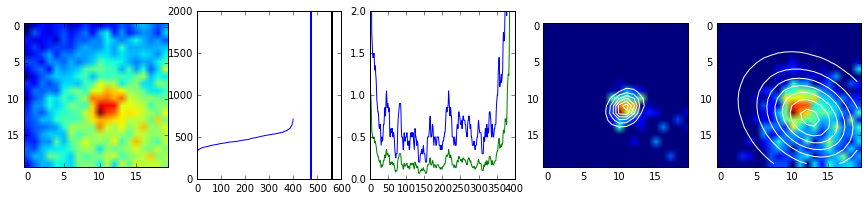

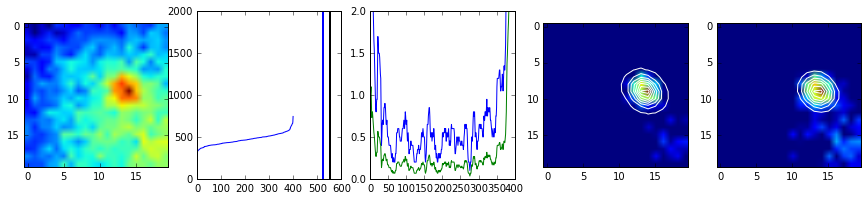

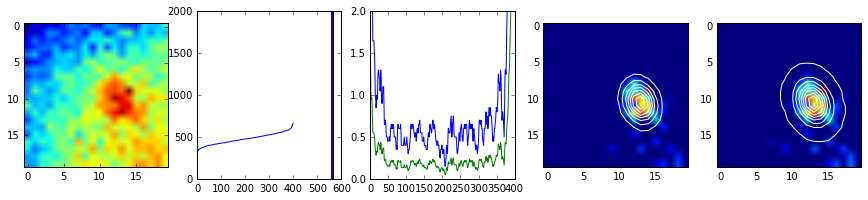

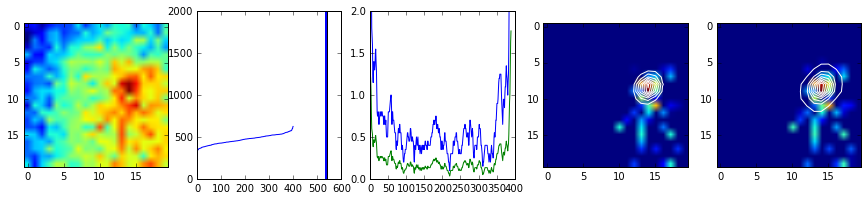

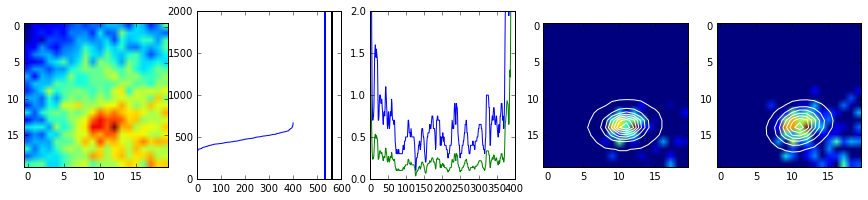

In [42]:
poptFrameBefore = [0,0,0,0,0,0,0];

for frameId in range(0,49):
#for frameId in range(0,5):
    trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
    trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
    #use the average coordinate else
    stack = stackA
    #pixels plotted around the center of the puncta
    padPM = 10
    frame = stack[frameId]
    y = int(trackXCoordinates[frameId]) +1
    x = int(trackYCoordinates[frameId]) +1
    
    particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]
    
    # Idea:
    # refine the image coordinate by taking the maximum from the just cropped image as the center point of 
    # a new image
    # Try that sometime
    
    fig, axs = plt.subplots(1, 5)
    ax = axs[0]
    ax.imshow(particleImage)
    
    
    
    
    
    # clip away all values that we think do not fit
    #http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.clip.html
    
    # we take the top 10%
    clipingIndex = int( 0.9* len(particleImage.flatten()))

    lowClipping = np.sort(particleImage.flatten())[clipingIndex]
    #print(clipingIndex,lowClipping)
    
    # better clipping index:
    # the first index that is larger than 5 in the gradient distance 1.
    # but only search for that in the top 50% of the pixels
    
    mavg = 10
    gradDist = 3
    threshold = 0.3
    
    findIndexIn = moving_average(np.gradient(np.sort(particleImage.flatten()),gradDist),mavg)
    totalLen = len(findIndexIn)
    findIndexAfter = int(0.5*totalLen)

    clippingIndex2 = findIndexAfter + next(x[0] for x in enumerate(findIndexIn[findIndexAfter:totalLen]) if x[1] > threshold)
    lowClipping2 = np.sort(particleImage.flatten())[clippingIndex2]
    #print(clippingIndex2,lowClipping2)
    
    #------------------------------------------------------------
    
    ax = axs[1]
    ax.plot(np.sort(particleImage.flatten()))
    # plot a line: [x1,x2],[y1,y2]
    ax.plot([lowClipping, lowClipping], [0,2000], 'k-', lw=2)
    ax.plot([lowClipping2, lowClipping2], [0,2000], 'b-', lw=2)
    
    
    
    ax = axs[2]
    ax.plot(moving_average(np.gradient(np.sort(particleImage.flatten())),mavg))
    ax.set_ylim([0, 2])
    
    ax = axs[2]
    ax.plot(moving_average(np.gradient(np.sort(particleImage.flatten()),gradDist),mavg))
    ax.set_ylim([0, 2])

    #------------------------------------------------------------

    clippedParticleImage=np.clip(particleImage, lowClipping, np.max(particleImage))
    
    ax = axs[3]
    ax.imshow(clippedParticleImage, cmap=plt.cm.jet)#,origin='lower')
    maxIntensityCoords = getMaxIntensityCoordinates(clippedParticleImage)
    popt = fitGaussianGuess(clippedParticleImage,initial_guess = 
                          (np.max(clippedParticleImage),
                           maxIntensityCoords[0],
                           maxIntensityCoords[1],
                           5.,5.,
                           1.,
                           lowClipping))
    if(popt[0]!=0):
        x = range(0,len(clippedParticleImage))
        y = range(0,len(clippedParticleImage[0]))
        (x, y) = np.meshgrid(x, y)
            
        data_fitted = twoD_Gaussian((x, y), *popt)
    
        
        ax.contour(x, y, data_fitted.reshape(len(clippedParticleImage), len(clippedParticleImage)), 8, colors='w')
        #ax.set_title('-BG, cond 1, black')

    #------
    clippedParticleImage2=np.clip(particleImage, lowClipping2, np.max(particleImage))
    
    ax = axs[4]
    ax.imshow(clippedParticleImage2, cmap=plt.cm.jet)#,origin='lower')
    
    #popt = fitGaussian(clippedParticleImage2)
    maxIntensityCoords = getMaxIntensityCoordinates(clippedParticleImage2)
    # (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
#    if(poptFrameBefore[0]==0)
    popt = fitGaussianGuess(clippedParticleImage2,initial_guess = 
                          (np.max(clippedParticleImage2),
                           maxIntensityCoords[0],
                           maxIntensityCoords[1],
                           5.,5.,
                           1.,
                           lowClipping2))
#    else:
#        popt = fitGaussianGuess(clippedParticleImage2,initial_guess = 
#                            poptFrameBefore)
    if(popt[0]!=0):
        x = range(0,len(clippedParticleImage2))
        y = range(0,len(clippedParticleImage2[0]))
        (x, y) = np.meshgrid(x, y)
            
        data_fitted = twoD_Gaussian((x, y), *popt)
    
    
        ax.contour(x, y, data_fitted.reshape(len(clippedParticleImage2), len(clippedParticleImage2)), 8, colors='w')
        poptFrameBefore = popt
        #ax.set_title('-BG, cond 2, blue')
    else:
        print("lower treshold");
        clippedParticleImage2=np.clip(particleImage, 0.8*lowClipping2, np.max(particleImage))
        ax.imshow(clippedParticleImage2, cmap=plt.cm.jet)#,origin='lower')
        popt = fitGaussianGuess(clippedParticleImage2,initial_guess = poptFrameBefore)
        if(popt[0]!=0):
            x = range(0,len(clippedParticleImage2))
            y = range(0,len(clippedParticleImage2[0]))
            (x, y) = np.meshgrid(x, y)
            

            data_fitted = twoD_Gaussian((x, y), *popt)
        
        
            ax.contour(x, y, data_fitted.reshape(len(clippedParticleImage2), len(clippedParticleImage2)), 8, colors='w')
            #ax.set_title('-BG, cond 2, blue')
        else:
            print("no hope");
    
    
    
    
    fig.set_size_inches(15,3)
    fig.show()
    
    
    
    



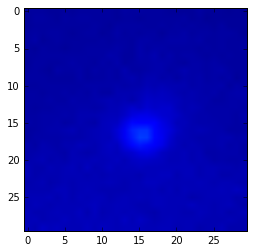

In [123]:
frameId=20
trackXCoordinates=np.array(trackToPlotCoordinates)[:,0]
trackYCoordinates=np.array(trackToPlotCoordinates)[:,1]
#use the average coordinate else
stack = stackA

#pixels plotted around the center of the puncta
padPM = 15

# the min and max values of the color map
vMax = np.max((stack[0]))
vMin = np.min((stack[0]))
  
frame = stack[frameId]
y = int(trackXCoordinates[0]) 
x = int(trackYCoordinates[0])

particleImage = frame[x-padPM:x+padPM,y-padPM:y+padPM]

plt.imshow(particleImage,vmin=vMin, vmax=vMax)
plt.colorbar(im,ax=ax)


In [48]:
#print(particleImage.reshape(len(particleImage)**2))

30
           initParam           popt           diff
amplitude      30000     838.471312   29161.528688
xo                15      15.434688      -0.434688
yo                15      16.465465      -1.465465
sigma_x            5       1.999765       3.000235
sigma_y            5       2.230134       2.769866
theta              1  122684.195594 -122683.195594
offset             1     360.094289    -359.094289


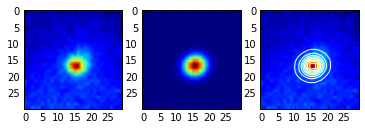

In [124]:
print(len(particleImage))
x = range(0,len(particleImage))
y = range(0,len(particleImage))
(x, y) = np.meshgrid(x, y)
# (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
initial_guess = (30000.,len(particleImage)/2.,len(particleImage)/2.,5.,5.,1.,1.)
popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), particleImage.reshape(len(particleImage)**2), p0=initial_guess)

#print(popt)
#print("so... the theta is switched and so is the sigma x and sigma y...")

import pandas
paramLabels = ["amplitude", "xo", "yo", "sigma_x", "sigma_y", "theta", "offset"]
asdf=pandas.DataFrame(zip( initial_guess, popt,initial_guess-popt),paramLabels,["initParam","popt","diff"])
print(asdf)



data_fitted = twoD_Gaussian((x, y), *popt)
#
#print(data_fitted)
#
fig, axs = plt.subplots(1, 3)
ax = axs[0]
ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')

ax = axs[1]
ax.imshow(data_fitted.reshape(len(particleImage), len(particleImage)))#,origin='lower')

ax = axs[2]
ax.hold(True)
ax.imshow(particleImage, cmap=plt.cm.jet)#,origin='lower')
ax.contour(x, y, data_fitted.reshape(len(particleImage), len(particleImage)), 8, colors='w')



In [51]:
print(fitGaussian(particleImage))

[633.42796437852894, 3.9911487217739783, 1092.1629816671239, 4.1482030014590023, 3.8340944420889547, 458.73501728859486]
